In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from envs import Maze
import matplotlib
from matplotlib import animation

from IPython.display import HTML
import seaborn as sns


pygame 2.5.2 (SDL 2.28.3, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

def plot_policy(probs_or_qvals, frame, action_meanings=None):
    if action_meanings is None:
        action_meanings = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    max_prob_actions = probs_or_qvals.argmax(axis=-1)
    probs_copy = max_prob_actions.copy().astype(object)
    for key in action_meanings:
        probs_copy[probs_copy == key] = action_meanings[key]
    sns.heatmap(max_prob_actions, annot=probs_copy, fmt='', cbar=False, cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.suptitle("Policy", size=18)
    plt.tight_layout()


def plot_values(state_values, frame):
    f, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(state_values, annot=True, fmt=".2f", cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.tight_layout()



def test_agent(environment, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, reward, done, extra_info = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)

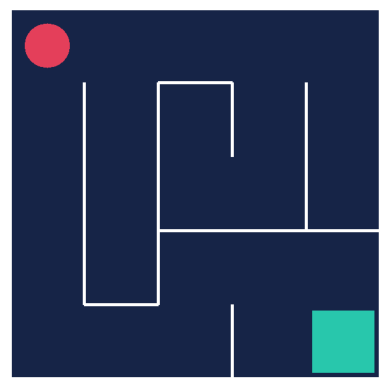

In [3]:
env = Maze()
env.reset()
frame = env.render(mode='rgb_array')
plt.axis("off")
plt.imshow(frame)

In [4]:
print(f'observation space shape: {env.observation_space.nvec}')
print(f'number of actions: {env.action_space.n}')

observation space shape: [5 5]
number of actions: 4


In [5]:
policy_probs = np.full((5, 5, 4), 0.25)

In [6]:
def policy(state):
    return policy_probs[state]

In [7]:
action_probabilities = policy((0, 0))
for action, prob in zip(range(4), action_probabilities):
    print(f'probability:{prob}, action:{action}')

probability:0.25, action:0
probability:0.25, action:1
probability:0.25, action:2
probability:0.25, action:3


In [8]:
test_agent(env, policy, episodes=1)

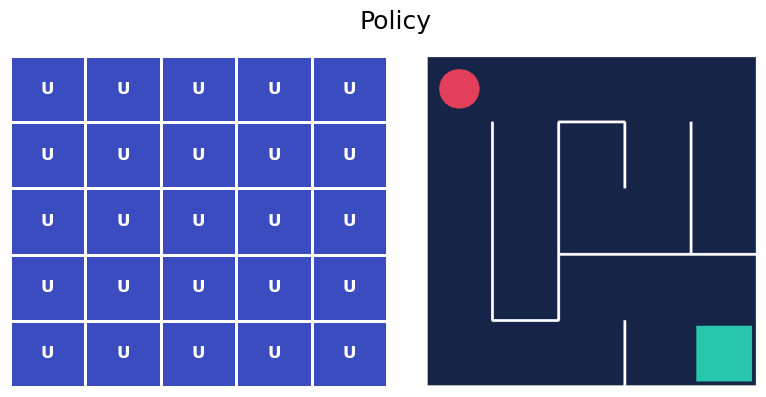

In [9]:
plot_policy(policy_probs, frame)

## Define value table V(s)

In [10]:
state_values = np.zeros(shape=(5, 5))

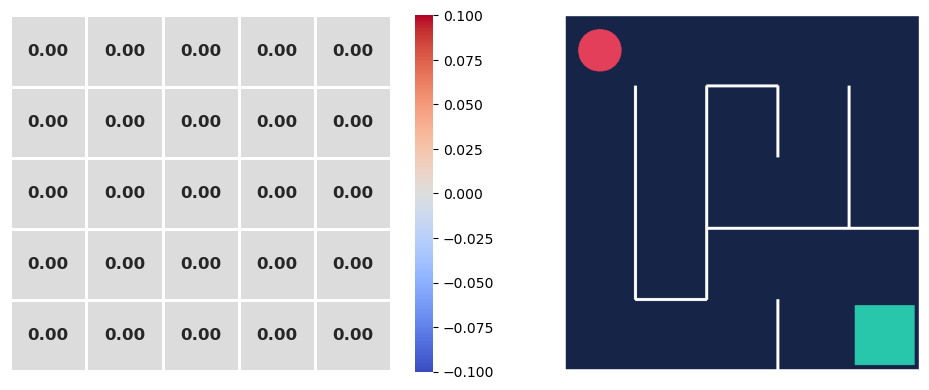

In [11]:
plot_values(state_values, frame)

## Implement the value Iteration algorithm

In [14]:
def value_iteration(policy_probs, state_values, theta=1e-6, gamma=0.99):
    delta = float("inf")
    
    while delta > theta:
        delta = 0
        for row in range(5):
            for col in range(5):
                old_value = state_values[(row, col)]
                action_probs = None
                max_qsa = float("-inf")
                
                for action in range(4):
                    next_state, reward, _, _ = env.simulate_step((row, col), action)
                    qsa = reward + gamma * state_values[next_state]
                    
                    if qsa > max_qsa:
                        max_qsa = qsa
                        action_probs = np.zeros(4)
                        action_probs[action] = 1.
                state_values[(row, col)] = max_qsa
                policy_probs[(row, col)] = action_probs
                
                delta = max(delta, abs(max_qsa - old_value))

In [15]:
value_iteration(policy_probs, state_values)